# Anomalies 

In [30]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

<AxesSubplot:xlabel='unix', ylabel='value'>

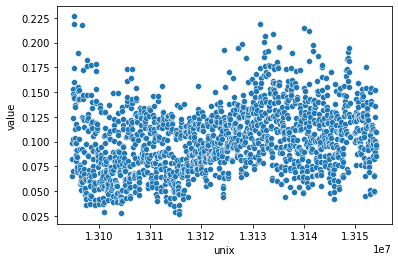

In [31]:
file_path = 'data/exchange-2_cpc_results.csv'
anomaly_data = pd.read_csv(file_path, parse_dates=['timestamp'])
anomaly_data['unix'] = (anomaly_data['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
anomaly_data.head()
sns.scatterplot(x=anomaly_data['unix'], y=anomaly_data['value'])

Now that we have our data loaded and analyzed, let's get into the engineering aspect of this project.

# Feature Engineering
Although we only have three attributes here (two given, one extracted) we can see pretty obviously some features we can pull. With timestamps, we can grab both hourly and weekly data. 

In [32]:
anomaly_data['hour'] = anomaly_data['timestamp'].dt.hour
anomaly_data['weekday'] = anomaly_data['timestamp'].dt.dayofweek

Let's also go ahead and include a feature that accounts for outliers. Right now we have values that are inherently larger than others. Let's generate a feature that defines a ceiling for normal values to fall under.

In [85]:
avg = 60
anomaly_data['avg']  = anomaly_data['value'].rolling(avg).sum()
anomaly_data['avg']  = anomaly_data['value'].apply(lambda v: v / 60)
anomaly_data['diff'] = anomaly_data.apply(lambda d: d['value'] - d['avg'], axis=1)
anomaly_data['diff'] = anomaly_data['diff'].fillna(0)

In [86]:
anomaly_data.head()

,timestamp,value,unix,hour,weekday,avg,diff
0,2011-07-01 00:00:01,0.081965,13094784,0,4,0.001366,0.080599
1,2011-07-01 01:00:01,0.098972,13094820,1,4,0.001650,0.097323
2,2011-07-01 02:00:01,0.065314,13094856,2,4,0.001089,0.064225
3,2011-07-01 03:00:01,0.070663,13094892,3,4,0.001178,0.069485
4,2011-07-01 04:00:01,0.102490,13094928,4,4,0.001708,0.100782


We'll go ahead and start our engineering by using IsolationForest for starters. We'll also include a convert method to extract a binary relationship for all our data. 
# IsolationForest

In [87]:
def to_anomaly(val):
    return ("Basic" if val == 1 else "Outlier")

model  = IsolationForest()
labels = model.fit_predict(anomaly_data[['value', 'hour', 'weekday', 'diff']])

<AxesSubplot:xlabel='unix', ylabel='value'>

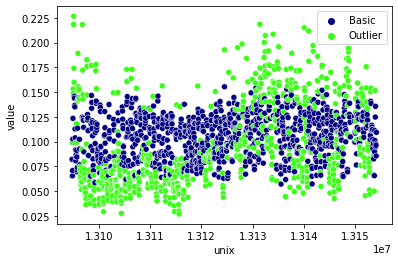

In [88]:
anomaly_lbls = list(map(to_anomaly, labels))
colors = {"Basic":"#000080", "Outlier":"#39FF14"}
sns.scatterplot(x=anomaly_data['unix'],y=anomaly_data['value'],hue=anomaly_lbls, palette=colors)

In [89]:
anomaly_lbls.count('Outlier') / len(anomaly_lbls)

0.43472906403940886

Interesting. The scatterplot makes it look like a decent portion of our data are outliers. Currently, **43%** of the set is labeled as an outlier. This is abnormal. We wouldn't expect for our dataset to include a high percentage of outliers. Let's utilize IsolationForest's contamination feature. Adding a contamination percentage will limit the number of anomalies. 

0.2001231527093596

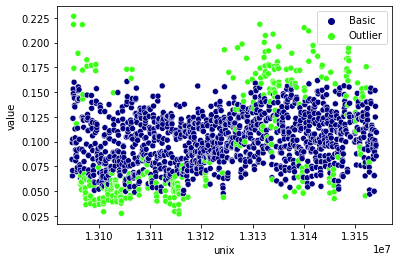

In [90]:
model  = IsolationForest(contamination=0.2)
labels = model.fit_predict(anomaly_data[['value', 'hour', 'weekday', 'diff']])
anomaly_lbls = list(map(to_anomaly, labels))
sns.scatterplot(x=anomaly_data['unix'],y=anomaly_data['value'], hue=anomaly_lbls, palette=colors)
anomaly_lbls.count('Outlier') / len(anomaly_lbls)

<AxesSubplot:xlabel='unix', ylabel='diff'>

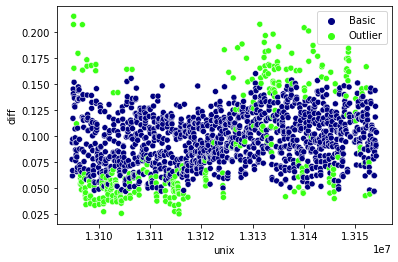

In [83]:
sns.scatterplot(x=anomaly_data['unix'],y=anomaly_data['diff'], hue=anomaly_lbls, palette=colors)

By using contamination, we can see our results changed alot. Now each of the plots have a limited outlier of 20%. Contamination allows us to normalize our dataset. This is helpful when beginning any feature engineering for any dataset because it can allow us to contain the percent of outliers we want to see.

Notice we don't see much of a difference between our **Value** plot and **Diff** plot. This is likely due to the fact that our **avg** column is a very small value and therefore the difference between diff and value is not significant. Let's use the LocalOutlierFactor to obtain more insight. 
# LocalOutlierFactor

In [84]:
model = LocalOutlierFactor(contamination=.02)
labels = model.fit_predict(anomaly_data[['value', 'hour', 'weekday', 'diff']])

<AxesSubplot:xlabel='unix', ylabel='value'>

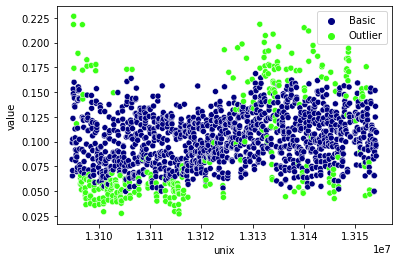

In [63]:
sns.scatterplot(x=anomaly_data['unix'], y=anomaly_data['value'], hue=anomaly_lbls, palette=colors)

<AxesSubplot:xlabel='unix', ylabel='diff'>

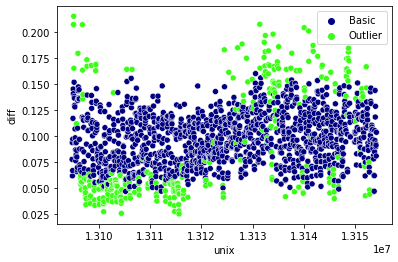

In [64]:
sns.scatterplot(x=anomaly_data['unix'], y=anomaly_data['diff'], hue=anomaly_lbls, palette=colors)

Cool. So it looks like LOF also gave us similar results to that of the IsolationForest, however it did not perform up to par as the former. 


# Conclusion
Sweet. We were able to establish a few different results. We know that both IF and LOF produce decent results although there is a weakness. The models both rely on knowing the percentage of anomalies in the dataset for proper execution. This is fragile in the case of run-time detection of errors and issues within our dataset. 

Within the context of this project, we could see how simple arithmetic/statistical processes can be much more direct and useful regarding the data provided.